The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

In [21]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import random
import zCurve as z
import math

Some "utils" functions:

In [22]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []

Fake data generation functions:

In [23]:
def compute_acceleration(pos_prev, pos_current, pos_next, dt):
    ax = (pos_next[0] - 2 * pos_current[0] + pos_prev[0]) / (dt ** 2)
    ay = (pos_next[1] - 2 * pos_current[1] + pos_prev[1]) / (dt ** 2)
    return ax, ay

def compute_relative_acceleration(pos_prev, pos_current, pos_next, dt):
    # Compute velocity vectors
    vx1 = (pos_current[0] - pos_prev[0]) / dt
    vy1 = (pos_current[1] - pos_prev[1]) / dt
    vx2 = (pos_next[0] - pos_current[0]) / dt
    vy2 = (pos_next[1] - pos_current[1]) / dt

    # Compute the change in velocity (acceleration vector)
    ax = (vx2 - vx1) / dt
    ay = (vy2 - vy1) / dt

    # Velocity direction (unit vector) at the middle position
    v_mag = math.hypot(vx1, vy1)
    if v_mag == 0:
        return 0.0, 0.0  # No motion

    # Tangential direction (unit vector)
    tx = vx1 / v_mag
    ty = vy1 / v_mag

    # Normal direction (perpendicular to tangential)
    nx = -ty
    ny = tx

    # Project acceleration onto tangential and normal directions
    a_tangential = ax * tx + ay * ty
    a_normal = ax * nx + ay * ny

    return a_normal, a_tangential

def generate_turning_data_3(num_points=100, left=True, initial_angle=math.pi/2, maxangle=math.pi/2, filename="trajectory.csv", initial_x=0, initial_y=0, initial_speed=5, changespeed=False):
    # Initialize variables
    position_x, position_y = initial_x, initial_y  # Start position
    previous_x, previous_y = initial_x, initial_y  # Start position
    
    turning_angle = initial_angle
    speed = initial_speed
    
    timestamp = 0
    delta_t = 4000  # Time step in microseconds
    padding = 15

    # Open CSV file for writing
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["sampleTimeStamp.seconds", "sampleTimeStamp.microseconds", "x", "y", "speed",
                         "turning_angle", "accel_x", "accel_y"])

        for i in range(-2, num_points):
            if padding < i < num_points - padding:     
                turning_angle = initial_angle - (i-padding)/(num_points-2*padding) * maxangle * (-1 if left else 1)

            speed = initial_speed + (2 * i/num_points if changespeed else 0) #+ 0.01*math.sin(i/num_points*7*math.pi)
            previous_previous_x = previous_x
            previous_previous_y = previous_y
            previous_x = position_x
            previous_y = position_y
            position_x = position_x + math.cos(turning_angle) * speed * 16/delta_t
            position_y = position_y + math.sin(turning_angle) * speed * 16/delta_t
            
            acceleration_x, acceleration_y = compute_relative_acceleration((previous_previous_x, previous_previous_y), (previous_x, previous_y), (position_x, position_y), 50/delta_t)
            
            if i < 0:
                continue
            
            writer.writerow([int(timestamp / 1000000), timestamp % 1000000, position_x, position_y, speed, turning_angle, acceleration_x, acceleration_y])
            timestamp += delta_t
    
    return turning_angle, speed, position_x, position_y

Synthetic data generation:

In [24]:
# =====================================
# GENERATE SYNTHETIC TURNS
# =====================================
left = True 
for left in [True, False]:
    for id in range(1, 10):
        for speed in range(5, 6):
            maxangle = math.pi/2 + (id*math.pi/15)
            # filename = "results/synthetic_turns_data/turn"+("left" if left else "right")+"_radius"+str(id)+"_speed"+str(speed)+".csv"
            filename = "results/synthetic_turns_data/"+("left" if left else "right")+"_turn_"+str(id)+".csv"
            generate_turning_data_3(num_points=60+id*50, left=left, initial_angle=math.pi/2, maxangle=maxangle, filename=filename, initial_x=0, initial_y=0, initial_speed=speed, changespeed=True)

Synthetic data visualisation:

results/synthetic_turns_data//right_turn_9.csv


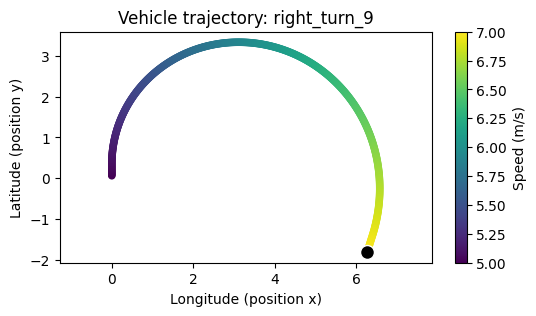

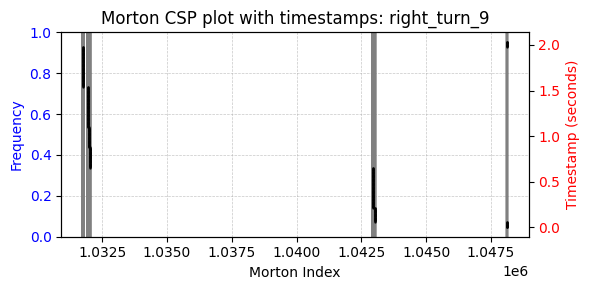

results/synthetic_turns_data//right_turn_8.csv


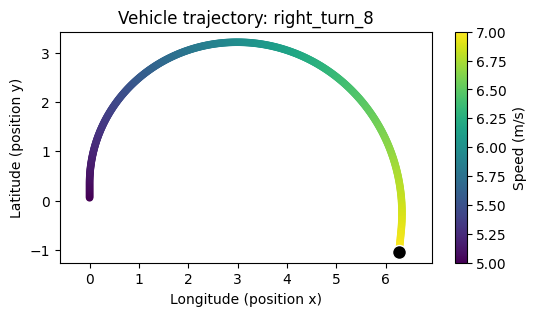

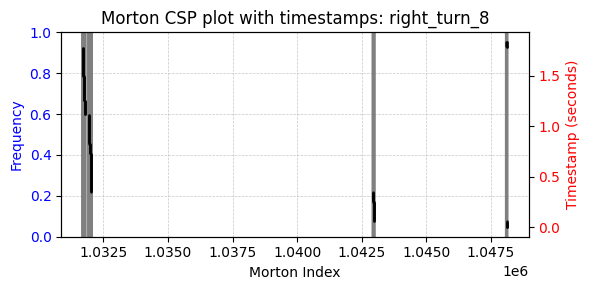

results/synthetic_turns_data//right_turn_7.csv


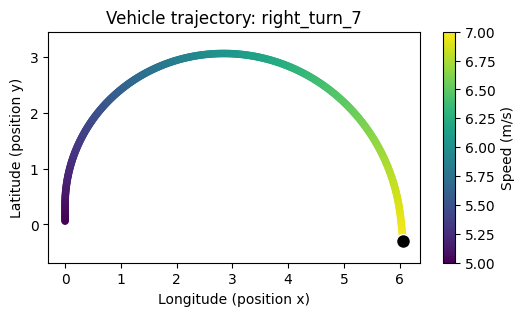

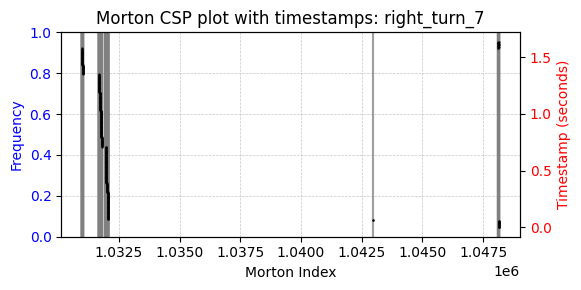

results/synthetic_turns_data//right_turn_6.csv


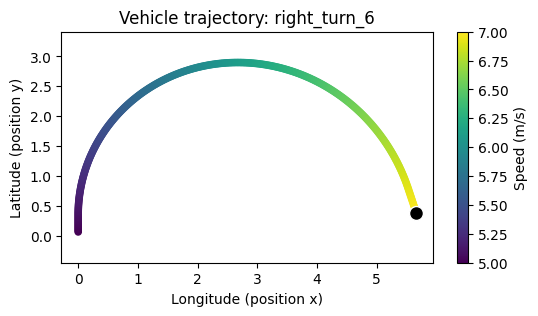

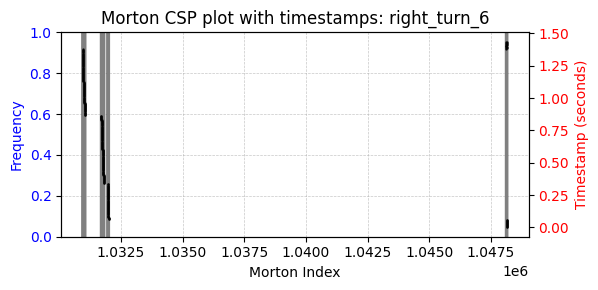

results/synthetic_turns_data//right_turn_5.csv


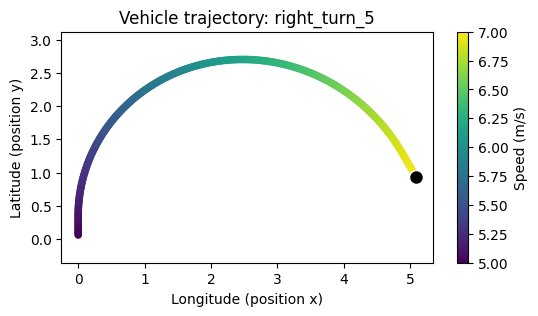

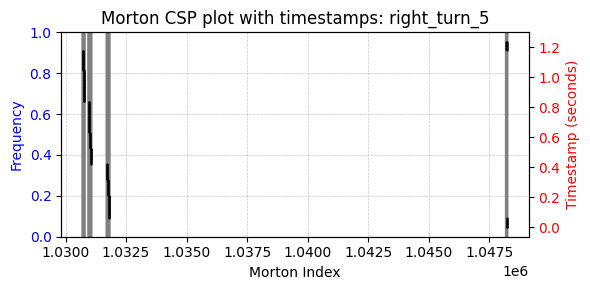

results/synthetic_turns_data//right_turn_4.csv


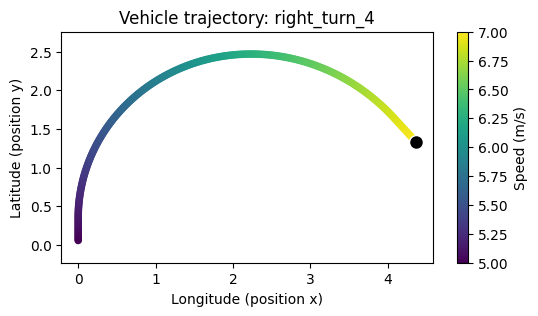

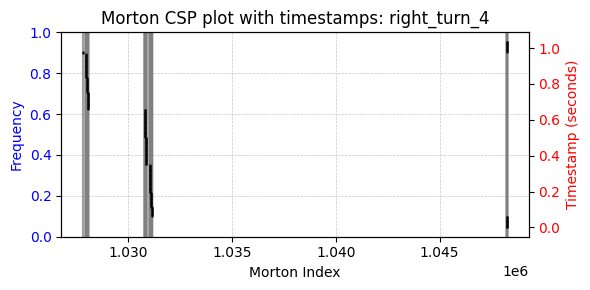

results/synthetic_turns_data//right_turn_3.csv


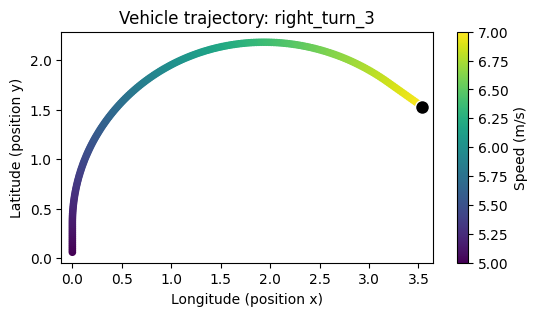

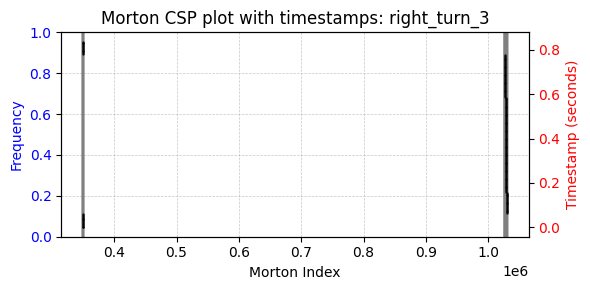

results/synthetic_turns_data//right_turn_2.csv


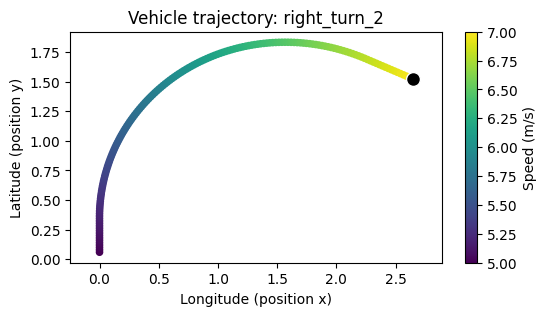

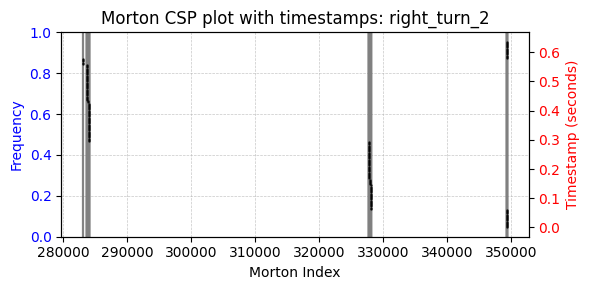

results/synthetic_turns_data//right_turn_1.csv


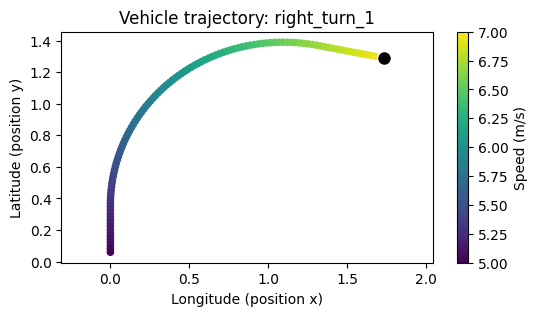

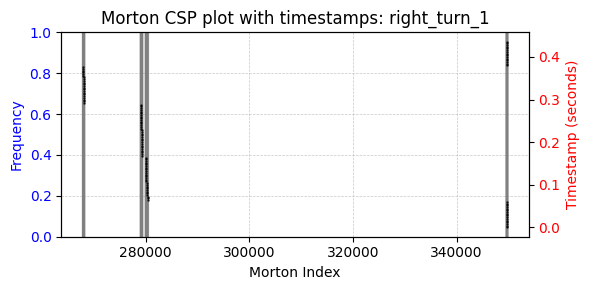

results/synthetic_turns_data//left_turn_9.csv


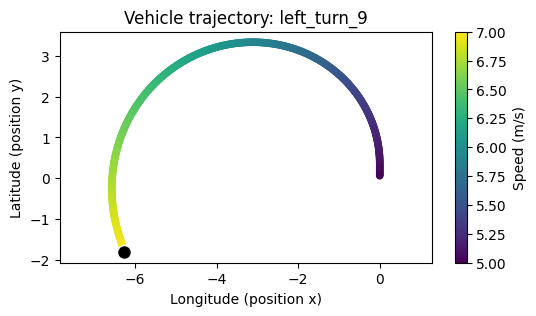

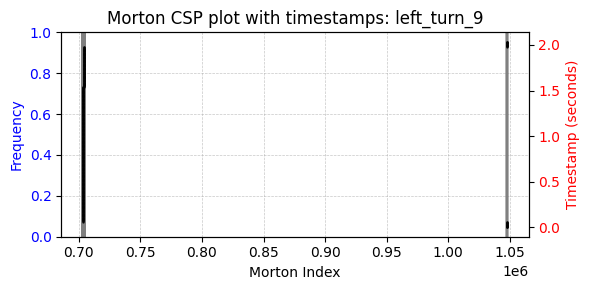

results/synthetic_turns_data//left_turn_8.csv


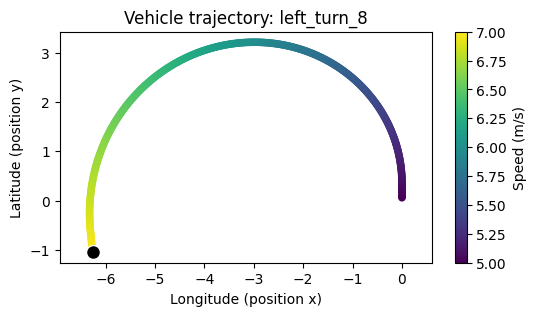

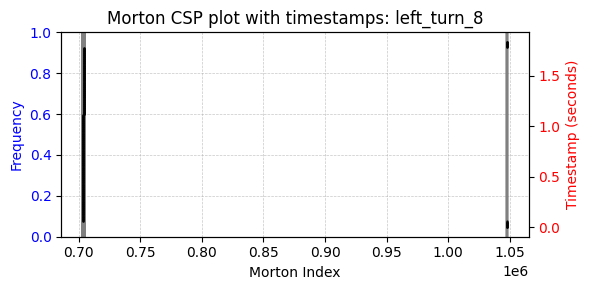

results/synthetic_turns_data//left_turn_7.csv


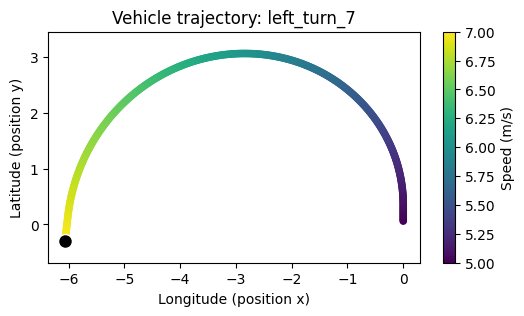

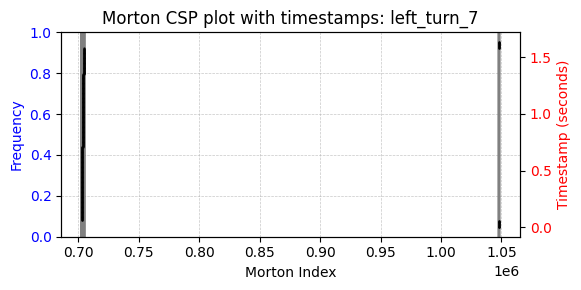

results/synthetic_turns_data//left_turn_6.csv


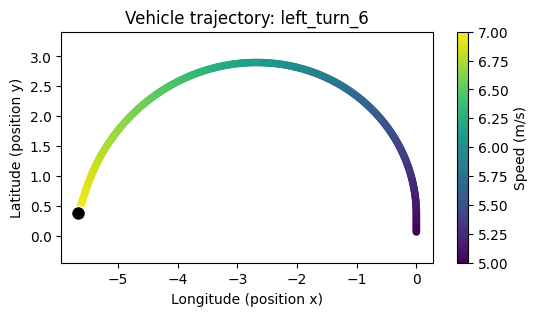

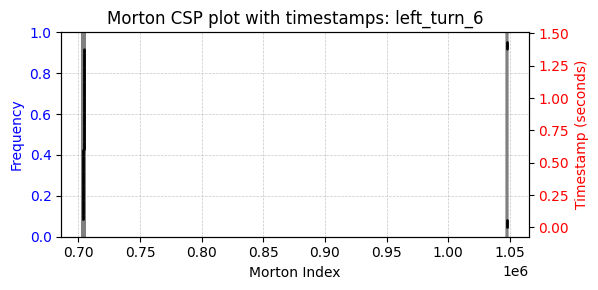

results/synthetic_turns_data//left_turn_5.csv


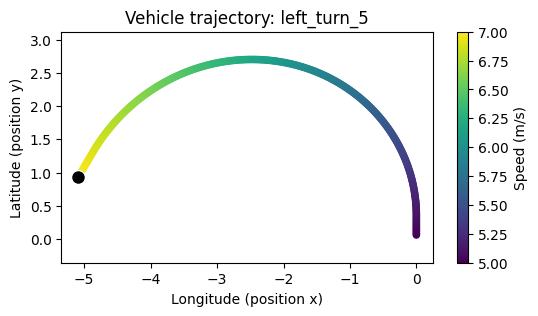

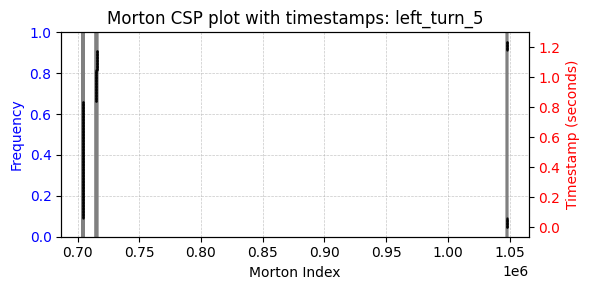

results/synthetic_turns_data//left_turn_4.csv


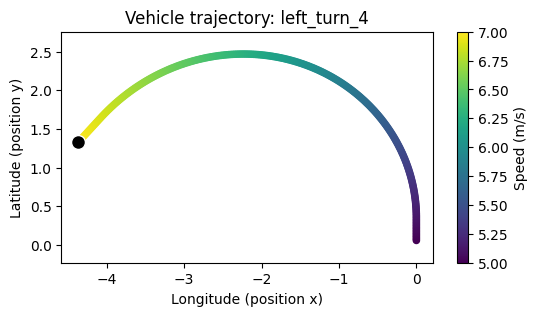

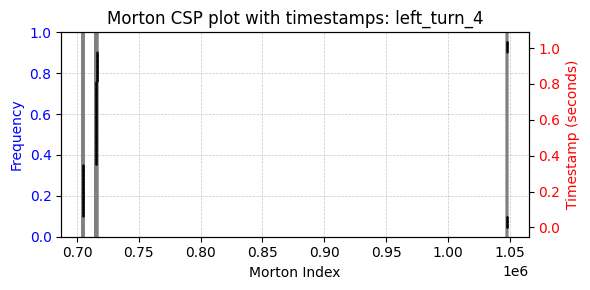

results/synthetic_turns_data//left_turn_3.csv


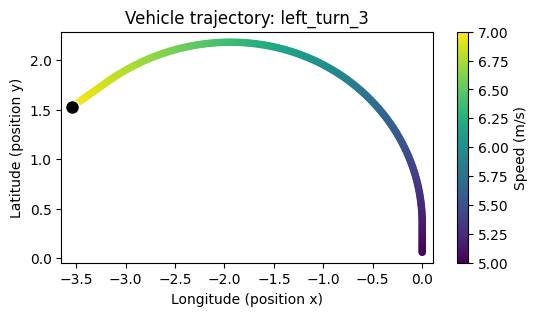

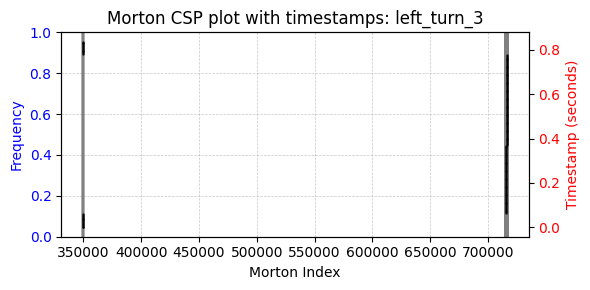

results/synthetic_turns_data//left_turn_2.csv


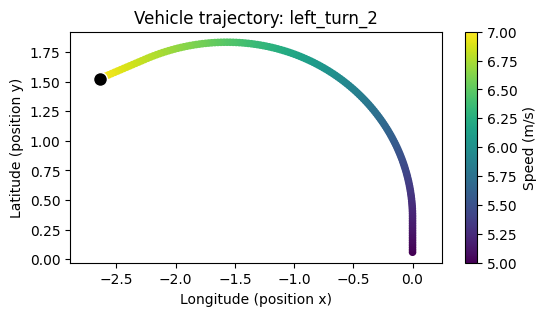

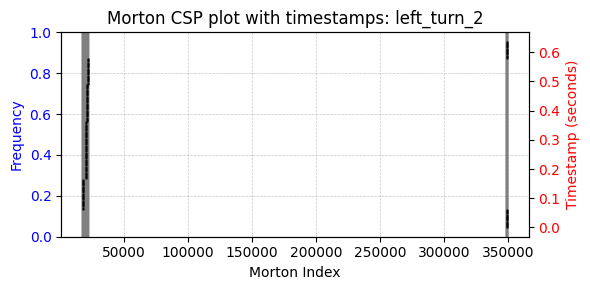

results/synthetic_turns_data//left_turn_1.csv


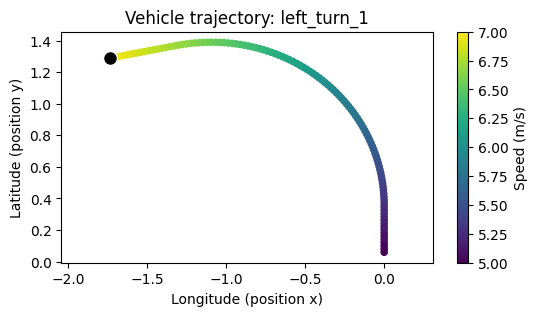

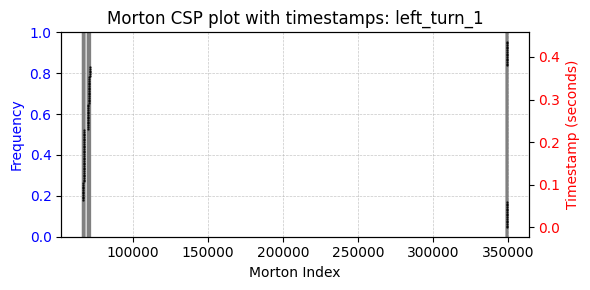

All files processed and plots saved.


In [25]:
# =====================================
# CHECK REAL TRAJECTORIES
# =====================================

common_figsize = (6, 3)  # Common figure size for all plots
output_dir = "results/synthetic_turns_data/plots"  # Folder to save plots
os.makedirs(output_dir, exist_ok=True)

# ===============================
# Data File Processing
# ===============================
data_files = get_files_in_folder("results/synthetic_turns_data/")
data_files.sort()
data_files.reverse()

# ===============================
# DATA FILE PROCESSING
# ===============================
for file_path in data_files:
    if ".csv" not in file_path:
        continue
    
    print(file_path)

    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    data = pd.read_csv(file_path, sep=';')
        
    data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']

    # ===============================
    # Plot 1: Vehicle Position Colored by Speed
    # ===============================    
    plt.figure(figsize=common_figsize)
    plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20, vmin=5, vmax=7)
    plt.colorbar(label="Speed (m/s)")
    plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
    plt.xlabel("Longitude (position x)")
    plt.ylabel("Latitude (position y)")
    plt.title(f"Vehicle trajectory: {file_basename}")
    plt.axis('equal')
    plot1_filename = os.path.join(output_dir, f"{file_basename}_position.png")
    plt.savefig(plot1_filename, bbox_inches="tight")
    plt.show()
    plt.close()
        
    # ===============================
    # Plot 1: Speed
    # ===============================    
    plt.figure(figsize=common_figsize)
    plt.plot(data['timestamp']/1000000.0, data["speed"], label="Speed", linewidth=1.5)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Speed (m/s)")
    plt.title(f"Speed vs Time\n{file_basename}")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc="upper right")
    plot2_filename = os.path.join(output_dir, f"{file_basename}_speed.png")
    plt.savefig(plot2_filename, bbox_inches="tight")
    # plt.show()
    plt.close()
    
    # ===============================
    # Plot 2: Raw Acceleration vs Time (No Smoothing)
    # ===============================
    min_accel_x = -3
    min_accel_y = -3
    max_accel_x = 3
    max_accel_y = 3
   
    accel_x = data["accel_x"]
    accel_y = data["accel_y"]
    # accel_x = (data["accel_x"] - min_accel_x)
    # accel_y = (data["accel_y"] - min_accel_y)
   
    plt.figure(figsize=common_figsize)
    plt.plot(data['timestamp']/1000000.0, accel_x, label="Accel X", color='red', linewidth=1.5)
    plt.plot(data['timestamp']/1000000.0, accel_y, label="Accel Y", color='green', linewidth=1.5)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Acceleration vs Time\n{file_basename}")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc="upper right")
    plot2_filename = os.path.join(output_dir, f"{file_basename}_signals_transformed.png")
    plt.savefig(plot2_filename, bbox_inches="tight")
    # plt.show()
    plt.close()

    accel_x = (data["accel_x"] + 10) * 100.0
    accel_y = (data["accel_y"] + 10) * 100.0

    # -------------------------------
    # Build Morton (Z-order) Index (if chosen or if building both)
    # -------------------------------
    data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=10) for x, y in zip(accel_x, accel_y)]
    fig, ax1 = plt.subplots(figsize=common_figsize)
    ax1.eventplot(data['Morton_Index'],
                  orientation='horizontal',
                  colors=["gray"],
                  alpha=0.5,
                  lineoffsets=0.5)
    ax1.set_xlabel("Morton Index")
    ax1.set_ylabel('Frequency', color='b')
    ax1.set_ylim((0, 1))
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.scatter(data['Morton_Index'],
                data['timestamp']/1000000.0,
                color='black',
                s=0.5,
                alpha=0.8,
                label="Timestamps")
    ax2.set_ylabel("Timestamp (seconds)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # ax1.set_xlim(0, 2000000) #set once the CSPs are analysed!

    plt.title(f"Morton CSP plot with timestamps: {file_basename}")
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plot_morton_filename = os.path.join(output_dir, f"{file_basename}_morton.png")
    plt.savefig(plot_morton_filename, bbox_inches="tight")
    plt.show()
    plt.close()

print("All files processed and plots saved.")